# Diet Metrics Definition & QA 

### Data Analytics & Data Science

### Objectives

-   Document the most critical Diet metrics
-   Source of truth for both Data Analytics & Data Science teams
-   Run quick QA on these most critical metrics

<h3>Table of Contents</h3>

<div class="alert alert-block alert-info" style="margin-top: 15px">
<ol>
    <li><a href="#acquisition"><b>Acquisition</b></a>
        <ul>
            <li><a href="#primary_sales">Primary Sales</a>
            <li><a href="#upsells">Upsells</a>
            <li><a href="#renewals">Renewals</a>
            <li><a href="#gross_revenue">Gross Revenue</a>   
            <li><a href="#aov">AOV (Average Order Value)</a>
            <li><a href="#adspent">AdSpent</a>
            <li><a href="#cpa">CPA (Cost Per Acquisition)</a>
            <li><a href="#unique_sessions">Unique Sessions</a>
            <li><a href="#cr">CR (Conversion Rate)</a>
        </ul>
<br>
    <li><a href="#retention"><b>Retention</b></a></li>
        <ul>
            <li><a href="#retention_metric_1">Retention Metric 1</a>
            <li><a href="#retention_metric_2">Retention Metric 2</a>
            <li><a href="#retention_metric_3">Retention Metric 3</a>
            <li><a href="#retention_metric_4">Retention Metric 4</a>
            <li><a href="#retention_metric_4">Retention Metric 5</a>
        </ul>
<br>
    <li><a href="#others"><b>Others</b></a></li>
        <ul>
            <li><a href="#kcollagen">Kcollagen Cost</a>
        </ul>
</ol>

</div>
<hr>

<h3>Deal with test users</h3>

<div class="alert alert-warning" style="margin-top: 15px">

Test users are excluded from all the following queries. All users whose emails ends with <b>'@teamcmp.com'</b> and <b>'@moarmarketing.com'</b> are considered as test users, and therefore, excluded from all the following results.

</div>
<hr>

In [48]:
import sys
import os
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from datetime import timedelta
from cmpdata.databases.util import read_rd_query, read_legacy_query, get_sql_query
#from utils import functions

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
db_config = yaml.safe_load(open(os.path.expanduser('~/.dbconfig/db_config_parameters.yml'), 'r'))

In [37]:
params = {'start_date': '2021-01-01'}

<h2 id="acquisition">Acquisition</h2>
<h3 id="primary_sales">Primary Sales</h3>
<br>
Primary sales are subscriptions to 1,2,3,6 or 12 months plans. 
<br>

<b>Table</b>: <code>kb.membership_created</code>
<br>

- <code>product_id</code> <b>=</b> <code>1</code>

In [43]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/primary_sales_query.sql')) % params['start_date']
df_primary_sales = read_rd_query(query, **db_config['redshift_config'])

df_primary_sales.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days Primary Sales
df_primary_sales.head(7)

,date,primary_sales
0,2021-07-28,62
1,2021-07-27,177
2,2021-07-26,121
3,2021-07-25,79
4,2021-07-24,55
5,2021-07-23,64
6,2021-07-22,54


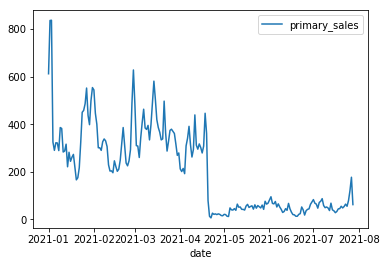

In [54]:
_ = df_primary_sales.set_index('date')
_.plot()

In [42]:
# save to data folder
df_primary_sales.to_csv(
    os.path.join('../data/processed', 'daily_primary_{}.csv'.format(pd.to_datetime('now').strftime('%d%m%y'))))

<u><h3 id="upsells">Upsells</h3></u>
<br>
Upsells are additional products users can buy after subscribing to a meal plan (primary sale). 
<br>

<b>Table</b>: <code>kb.membership_created</code>
<br>

- <code>product_id</code> <b>!=</b> <code>1</code>

In [44]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/upsells_query.sql')) % params['start_date']
df_upsells = read_rd_query(query, **db_config['redshift_config'])

df_upsells.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days Upsells
df_upsells.head(7)

,date,upsells
0,2021-07-28,33
1,2021-07-27,241
2,2021-07-26,198
3,2021-07-25,47
4,2021-07-24,43
5,2021-07-23,114
6,2021-07-22,30


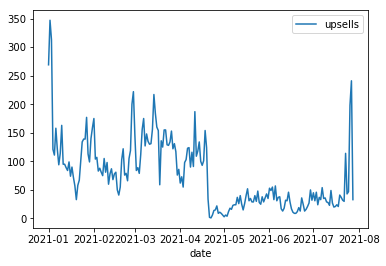

In [46]:
_ = df_upsells.set_index('date')
_.plot()

In [45]:
# save to data folder
df_upsells.to_csv(
    os.path.join('../data/processed', 'daily_upsells_{}.csv'.format(pd.to_datetime('now').strftime('%d%m%y'))))

<u><h3 id="renewals">Renewals</h3></u>
<br>
Renewals are rebilled transactions on the 1,2,3,6 or 12 months plans.
<br>

<b>Table</b>: <code>kb.recurly_transactions</code>


- <code>origin</code> <b>=</b> <code>'recurring'</code>
- <code>status</code> <b>=</b> <code>'success'</code>

In [47]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/renewals_query.sql')) % params['start_date']
df_renewals = read_rd_query(query, **db_config['redshift_config'])

df_renewals.sort_values(by='renewal_date', ascending=False, inplace=True)

# Show last 7 days Renewals
df_renewals.head(7)

,renewal_date,renewals
0,2021-07-27,139
1,2021-07-26,128
2,2021-07-25,120
3,2021-07-24,132
4,2021-07-23,100
5,2021-07-22,61
6,2021-07-21,69


In [ ]:
#plot

<u><h3 id="gross_revenue">Gross Revenue</h3></u>
<br>
The Gross Revenue represents the total amount spent by members in primary plans, upsells and complements.
<br>

As we operate on multiple currencies, the Gross Revenue needs to be converted in USD
<br>

<b>Tables</b>: <code>kb.membership_created</code> & <code>etl.currency_conversions</code>

In [55]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/gross_revenue_query.sql')) % params['start_date']
df_gross_revenue = read_rd_query(query, **db_config['redshift_config'])

df_gross_revenue.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days Gross Revenue
df_gross_revenue.head(7)

,date,gross_revenue_usd
0,2021-07-28,2183.0
1,2021-07-27,7610.0
2,2021-07-26,7098.0
3,2021-07-25,4004.0
4,2021-07-24,2875.0
5,2021-07-23,4717.0
6,2021-07-22,2700.0


In [ ]:
# plot

<u><h3 id="aov">AOV (Average Order Value)</h3></u>
<br>
The AOV (Average Order Value) represents the average amount spent beach time a member places an order.
<br>

<b>Table</b>: <code>kb.membership_created</code>


- <code>AOV Primary Sales</code> <b>=</b> <code>Gross Revenue USD from Primary Sales / Primary Sales</code>
- <code>AOV Upsells</code> <b>=</b> <code>Gross Revenue USD from Upsells / Primary Sales </code>
- <code>AOV Total</code> <b>=</b> <code>(Gross Revenue USD from Primary Sales + Upsells) / Primary Sales </code>

In [57]:
# Total AOV calculation using both df_primary_sales and df_gross_revenue
total_aov = round((df_gross_revenue['gross_revenue_usd']/df_primary_sales['primary_sales']),2)
df_gross_revenue['total_aov'] = total_aov

# Show last 7 days Total AOV
df_gross_revenue.head(7)

,date,gross_revenue_usd,total_aov
0,2021-07-28,2183.0,35.21
1,2021-07-27,7610.0,42.99
2,2021-07-26,7098.0,58.66
3,2021-07-25,4004.0,50.68
4,2021-07-24,2875.0,52.27
5,2021-07-23,4717.0,73.70
6,2021-07-22,2700.0,50.00


In [58]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/aov_query.sql')) % params['start_date']
df_aov = read_rd_query(query, **db_config['redshift_config'])

df_aov.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days AOV broken down per Primary Sales and Upsells
df_aov.head(14)

,date,product_type,transactions,gross_revenue_usd,aov
0,2021-07-28,primary,64,1983.0,30.98
1,2021-07-28,upsells,35,200.0,5.71
2,2021-07-27,primary,177,6046.0,34.16
3,2021-07-27,upsells,241,1564.0,6.49
4,2021-07-26,primary,121,5340.0,44.13
5,2021-07-26,upsells,198,1758.0,8.88
6,2021-07-25,primary,79,3736.0,47.29
7,2021-07-25,upsells,47,268.0,5.70
8,2021-07-24,primary,55,2593.0,47.15
9,2021-07-24,upsells,43,282.0,6.56


<h3 id="adspent">AdSpent</h3>
<br>
Budget spent across all Ad Marketing plateforms (Facebook Ads, Google Ads etc.)
<br>

<b>Table</b>: <code>funnel_io.adspent</code>
<br>

- <code>product_name</code> <b>=</b> <code>KetoBody</code>

In [59]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/adspent_query.sql')) % params['start_date']
df_adspent = read_rd_query(query, **db_config['redshift_config'])

df_adspent.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days AdSpent
df_adspent.head(7)

,date,adspent
0,2021-07-28,2782.79
1,2021-07-27,7480.06
2,2021-07-26,6374.26
3,2021-07-25,5653.09
4,2021-07-24,3831.39
5,2021-07-23,3010.69
6,2021-07-22,3847.15


<h3 id="cpa">CPA (Cost Per Acquisition)</h3>
<br>
The CPA (Cost Per Acquisition) measures the aggregate cost to acquire one paying customer.
<br>

<b>Tables</b>: <code>kb.membership_created</code> & <code>funnel_io.adspent</code>
<br>

- <code>CPA</code> <b>=</b> <code>AdSpent / Primary Sales</code>

In [67]:
# CPA calculation using both df_primary_sales and df_adspent
df_cpa = round((df_adspent['adspent']/ df_primary_sales['primary_sales']),2)
df_adspent['cpa'] = df_cpa

df_adspent.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days CPA
df_adspent.head(7)

,date,adspent,cpa
0,2021-07-28,2782.79,44.88
1,2021-07-27,7480.06,42.26
2,2021-07-26,6374.26,52.68
3,2021-07-25,5653.09,71.56
4,2021-07-24,3831.39,69.66
5,2021-07-23,3010.69,47.04
6,2021-07-22,3847.15,71.24


<h3 id="unique_sessions">Unique Sessions</h3>
<br>
Unique sessions to each of our active tours. 
<br>

<b>Table</b>: <code>kb.tour_steps</code>
<br>

- <code>tour_step</code> <b>=</b> <code>0</code>, to catch all visitors starting at the first step of the tour

In [63]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/unique_sessions_query.sql')) % params['start_date']
df_unique_sessions = read_rd_query(query, **db_config['redshift_config'])

df_unique_sessions.sort_values(by='date', ascending=False, inplace=True)

# Show last 7 days AdSpent
df_unique_sessions.head(7)

,date,unique_sessions
0,2021-07-28,2989
1,2021-07-27,6064
2,2021-07-26,5938
3,2021-07-25,5195
4,2021-07-24,3594
5,2021-07-23,3014
6,2021-07-22,3703


<h3 id="cr">CR (Conversion Rate)</h3>
<br>
The CR (Conversion Rate) measures the conversion between all the users reaching our active tours and the ones who end up subscribing to the product (Primary Sales).
<br>

<b>Tables</b>: <code>kb.membership_created</code> & <code>kb.tour_steps</code>
<br>

- <code>CR</code> <b>=</b> <code>Primary Sales / Unique Sessions</code>

In [66]:
# CR calculation using both df_primary_sales and df_unique_sessions
df_cr = round(((df_primary_sales['primary_sales']/df_unique_sessions['unique_sessions'])*100),2)
df_unique_sessions['cr'] = df_cr

# Show last 7 days CPA
df_unique_sessions.head(7)

,date,unique_sessions,cr
0,2021-07-28,2989,2.07
1,2021-07-27,6064,2.92
2,2021-07-26,5938,2.04
3,2021-07-25,5195,1.52
4,2021-07-24,3594,1.53
5,2021-07-23,3014,2.12
6,2021-07-22,3703,1.46


<h3 id="al">Activity Level</h3>
<br>
Activity Level measures the number of days with at least one login in four windows; 2 days, 7 days, 15 days and 30 days.
<br>

<b>Tables</b>: <code>kb.user_logged</code>
<br>

In [69]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/logins_query.sql')) % params['start_date']
df_logins = read_rd_query(query, **db_config['redshift_config'])

df_logins.sort_values(by='logged_at', ascending=False, inplace=True)

df_logins.head()

,event_id,user_id,membership_id,membership_status,logged_at,user_logged_in_count,user_agent,browser,browser_version,device_brand,device_family,device_model,is_bot,os_family,os_version,email
371270,95401938-4fe7-4d61-825d-c9279ac18a8a,1139865,105889,active,2021-07-28 14:34:38,4.0,Mozilla/5.0 (Linux; Android 11; Pixel 2) Apple...,Chrome Mobile,91.0.4472,Generic,Generic Smartphone,Smartphone,False,Android,,quietvioletforest@yahoo.com
353089,58eeb04f-7be8-49a7-9a9a-2938c3292a48,468266,49279,active,2021-07-28 14:33:01,132.0,Mozilla/5.0 (iPhone; CPU iPhone OS 14_2 like M...,Mobile Safari UI/WKWebView,14.2,Apple,"iPhone12,1","iPhone12,1",False,iOS,14.2,cheryl.rhen@yahoo.com
351804,a8a06feb-8aec-409e-bf0f-c57fba312087,1130877,104946,active,2021-07-28 14:33:00,59.0,Mozilla/5.0 (iPhone; CPU iPhone OS 13_6 like M...,Mobile Safari UI/WKWebView,13.6,Apple,"iPhone9,2","iPhone9,2",False,iOS,13.6,mymamaw0604@gmail.com
373108,c19cddf6-12fc-4c03-a379-f9ee2be4d946,616197,61237,active,2021-07-28 14:32:09,3.0,Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like M...,Mobile Safari,14.0.2,Apple,iPhone,iPhone,False,iOS,14.3,dawnvail2@gmail.com
351802,b1f9a22e-8160-48ce-9007-d7004615284b,1085983,100530,active,2021-07-28 14:28:59,79.0,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,Mobile Safari,14.0.3,Apple,iPhone,iPhone,False,iOS,14.4.2,cwsipe@yahoo.com


In [70]:
# get first logged timestamp
df_logins['first_logged_at'] = df_logins.groupby(['email'])['logged_at'].transform('min')

#### Activity Level Function

In [71]:
def activity_level(df, window):
    df[['first_log_date', 'logged_date']] = df[['first_logged_at', 'logged_at']].values.astype('datetime64[D]')
    df.drop_duplicates(subset=['email', 'logged_date'], keep='first', inplace=True)
    
    time_window = (df['first_log_date'] + timedelta(days=window))
    members = df['membership_id'].nunique()
    act_level = df[df['logged_date']<time_window]['logged_date'].count()
    return act_level/members

In [72]:
print(activity_level(df_logins, 2))
print(activity_level(df_logins, 7))

1.2712886712664144
1.8776986423325173


<h2 id="others">Others</h2>
<h3 id="kcollagen">Kcollagen Cost</h3>
<br>
Shipping costs for Kcollagen complements sold to members.
<br>

<b>Table</b>: <code>kb.membership_created</code>
<br>

- <code>product_id</code> <b>IN</b> <code>(8, 9, 10)</code>

In [74]:
query = get_sql_query(os.path.join(os.getcwd(), '../data/queries/kcollagen_cost_query.sql')) % params['start_date']
df_kcollagen_cost = read_rd_query(query, **db_config['redshift_config'])

df_kcollagen_cost.sort_values(by='date', ascending=False, inplace=True)

# Show last 10 entries
df_kcollagen_cost.head(10)

,date,product_id,product_name,cost_per_unit,kcollagen_units_sold
0,2021-05-21,9,KCollagen 3-Pack,29.90,1
2,2021-04-20,9,KCollagen 3-Pack,29.90,4
1,2021-04-20,8,KCollagen 1-Pack,12.05,1
3,2021-04-19,8,KCollagen 1-Pack,12.05,8
4,2021-04-19,9,KCollagen 3-Pack,29.90,14
5,2021-04-18,8,KCollagen 1-Pack,12.05,9
6,2021-04-18,9,KCollagen 3-Pack,29.90,11
7,2021-04-18,10,KCollagen 6-Pack,44.50,1
9,2021-04-17,9,KCollagen 3-Pack,29.90,9
8,2021-04-17,8,KCollagen 1-Pack,12.05,6
